In [4]:
import jax.numpy as jnp
from jax import grad, jit

@jit
def matrix_multiply(a, b):
    return jnp.dot(a, b)

# Compute the gradient of the sum of the output with respect to the first input
grad_func = jit(grad(lambda a, b: jnp.sum(matrix_multiply(a, b))))

# Example usage
a = jnp.array([[1.0, 2.0], [3.0, 4.0]])
b = jnp.array([[5.0, 6.0], [7.0, 8.0]])

result = matrix_multiply(a, b)
gradient = grad_func(a, b)

print("Result:", result)
print("Gradient:", gradient)

Result: [[19. 22.]
 [43. 50.]]
Gradient: [[11. 15.]
 [11. 15.]]


In [6]:
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries import optimizers
import jax

def init_network_params(layer_sizes, key):
    keys = random.split(key, len(layer_sizes))
    return [random.normal(k, (m, n)) * jnp.sqrt(2/m)
            for k, m, n in zip(keys, layer_sizes[:-1], layer_sizes[1:])]

def forward(params, x):
    activations = x
    for w in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, w))
    return jnp.dot(activations, params[-1])

def loss(params, x, y):
    preds = forward(params, x)
    return jnp.mean((preds - y) ** 2)

@jit
def update(params, x, y, opt_state):
    value, grads = jax.value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Initialize parameters and optimizer
layer_sizes = [1, 32, 1]
params = init_network_params(layer_sizes, random.PRNGKey(0))
opt_init, opt_update, get_params = optimizers.adam(1e-2)
opt_state = opt_init(params)

# Training loop
for i in range(1000):
    x = random.normal(random.PRNGKey(i), (100, 1))
    y = x ** 2
    params, opt_state, loss_value = update(params, x, y, opt_state)
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss_value}")

# Test the trained network
x_test = jnp.array([[2.0]])
y_pred = forward(params, x_test)
print(f"Prediction for x=2: {y_pred[0][0]}")

Step 0, Loss: 3.407194137573242
Step 100, Loss: 1.945688247680664
Step 200, Loss: 2.6792654991149902
Step 300, Loss: 2.595205545425415
Step 400, Loss: 4.356526851654053
Step 500, Loss: 1.9102303981781006
Step 600, Loss: 5.1562018394470215
Step 700, Loss: 2.837627410888672
Step 800, Loss: 2.3896703720092773
Step 900, Loss: 1.2287392616271973
Prediction for x=2: 0.06474363803863525


In [3]:
import einops
import numpy as np

In [4]:
# Create two matrices
matrix_a = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

matrix_b = np.array([
    [7, 8],
    [9, 10],
    [11, 12]
])

print("Matrix A:")
print(matrix_a)
print("\nMatrix B:")
print(matrix_b)

# Perform matrix multiplication using einops
result = einops.einsum(matrix_a, matrix_b, 'i j, j k -> i k')

print("\nResult of A * B:")
print(result)

# Take mean of the first matrix (convert to float first)
matrix_a = matrix_a.astype(float)
mean = einops.reduce(matrix_a, 'i j ->', 'mean')
print("\nMean of matrix A:")
print(mean)

# Take mean along the columns of the first matrix
mean = einops.reduce(matrix_a, 'i j -> j', 'mean')
print("\nMean along columns of matrix A:")
print(mean)


Matrix A:
[[1 2 3]
 [4 5 6]]

Matrix B:
[[ 7  8]
 [ 9 10]
 [11 12]]

Result of A * B:
[[ 58  64]
 [139 154]]

Mean of matrix A:
3.5

Mean along columns of matrix A:
[2.5 3.5 4.5]


In [7]:
from einops import reduce, repeat, rearrange

# Create a sample 3D array (2x3x4)
data = np.array([
    [[1, 2, 3, 4],
     [5, 6, 7, 8],
     [9, 10, 11, 12]],
    [[13, 14, 15, 16],
     [17, 18, 19, 20],
     [21, 22, 23, 24]]
])
data = data.astype(float)

print("Original data shape:", data.shape)
print("Original data:\n", data)

# 1. Calculate mean across different dimensions
mean_across_first_dim = reduce(data, 'a b c -> b c', 'mean')
print("\nMean across first dimension:\n", mean_across_first_dim)

mean_across_last_dim = reduce(data, 'a b c -> a b', 'mean')
print("\nMean across last dimension:\n", mean_across_last_dim)

overall_mean = reduce(data, 'a b c -> ()', 'mean')
print("\nOverall mean:", overall_mean)

# 2. Duplication (repeating) data
duplicated = repeat(data, 'a b c -> a (b 2) c')
print("\nDuplicated data shape:", duplicated.shape)
print("First part of duplicated data:\n", duplicated)

# 3. Combine reduction and repeating
mean_and_broadcast = reduce(data, 'a b c -> () () c', 'mean')
mean_and_broadcast = repeat(mean_and_broadcast, '() () c -> a b c', a=2, b=3)
print("\nMean calculated and broadcast back to original shape:\n", mean_and_broadcast)


Original data shape: (2, 3, 4)
Original data:
 [[[ 1.  2.  3.  4.]
  [ 5.  6.  7.  8.]
  [ 9. 10. 11. 12.]]

 [[13. 14. 15. 16.]
  [17. 18. 19. 20.]
  [21. 22. 23. 24.]]]

Mean across first dimension:
 [[ 7.  8.  9. 10.]
 [11. 12. 13. 14.]
 [15. 16. 17. 18.]]

Mean across last dimension:
 [[ 2.5  6.5 10.5]
 [14.5 18.5 22.5]]

Overall mean: [12.5]

Duplicated data shape: (2, 6, 4)
First part of duplicated data:
 [[[ 1.  2.  3.  4.]
  [ 1.  2.  3.  4.]
  [ 5.  6.  7.  8.]
  [ 5.  6.  7.  8.]
  [ 9. 10. 11. 12.]
  [ 9. 10. 11. 12.]]

 [[13. 14. 15. 16.]
  [13. 14. 15. 16.]
  [17. 18. 19. 20.]
  [17. 18. 19. 20.]
  [21. 22. 23. 24.]
  [21. 22. 23. 24.]]]

Mean calculated and broadcast back to original shape:
 [[[11. 12. 13. 14.]
  [11. 12. 13. 14.]
  [11. 12. 13. 14.]]

 [[11. 12. 13. 14.]
  [11. 12. 13. 14.]
  [11. 12. 13. 14.]]]


In [13]:
new = rearrange(data, 'a b c -> (a b) (c)')
print(data)
print(new)

[[[ 1.  2.  3.  4.]
  [ 5.  6.  7.  8.]
  [ 9. 10. 11. 12.]]

 [[13. 14. 15. 16.]
  [17. 18. 19. 20.]
  [21. 22. 23. 24.]]]
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]
 [17. 18. 19. 20.]
 [21. 22. 23. 24.]]


In [2]:
import jax
import jax.numpy as jnp
from timeit import timeit

def simple_function(x, y):
    return jnp.sin(x) + jnp.cos(y)

# Create a JIT-compiled version of the function
jit_function = jax.jit(simple_function)

# Create some example data
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([4.0, 5.0, 6.0])

# First run: compilation occurs
print("First run (includes compilation time):")
print(timeit(lambda: jit_function(x, y), number=1))

# Subsequent runs: use compiled version
print("\nSubsequent runs (using compiled version):")
print(timeit(lambda: jit_function(x, y), number=1000))

# Compare with non-JIT version
print("\nNon-JIT version:")
print(timeit(lambda: simple_function(x, y), number=1000))

# Verify results are the same
print("\nResults:")
print("JIT:", jit_function(x, y))
print("Non-JIT:", simple_function(x, y))

First run (includes compilation time):
0.01810259697958827

Subsequent runs (using compiled version):
0.016837597941048443

Non-JIT version:
0.05155928595922887

Results:
JIT: [0.18782735 1.1929597  1.1012902 ]
Non-JIT: [0.18782735 1.1929597  1.1012902 ]


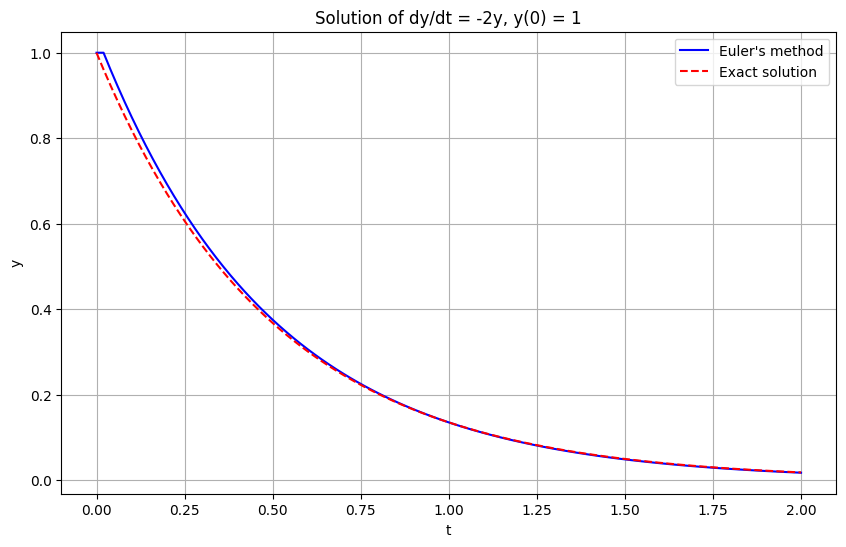

Maximum difference between JIT and non-JIT versions:
0.0


In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def eulers_method(f, y0, t_span, n_steps):
    """
    Implement Euler's method using jax.lax.scan.
    
    Args:
    f: function that defines the ODE dy/dt = f(t, y)
    y0: initial value
    t_span: tuple of (t_start, t_end)
    n_steps: number of steps

    Returns:
    t: array of time points
    y: array of solution values
    """
    t_start, t_end = t_span
    dt = (t_end - t_start) / n_steps
    
    def step(carry, _):
        t, y = carry
        y_next = y + dt * f(t, y)
        t_next = t + dt
        return (t_next, y_next), y

    t = jnp.linspace(t_start, t_end, n_steps + 1)
    _, y = jax.lax.scan(step, (t[0], y0), jnp.arange(n_steps))
    
    return t, jnp.concatenate([jnp.array([y0]), y])

# Example: solving dy/dt = -2y, y(0) = 1
def f(t, y):
    return -2 * y

y0 = 1.0
t_span = (0, 2)
n_steps = 100

t, y = eulers_method(f, y0, t_span, n_steps)

# JIT-compile the function
jit_eulers_method = jax.jit(eulers_method, static_argnums=(0, 3))
t_jit, y_jit = jit_eulers_method(f, y0, t_span, n_steps)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, y, 'b-', label="Euler's method")
plt.plot(t, jnp.exp(-2*t), 'r--', label='Exact solution')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.title("Solution of dy/dt = -2y, y(0) = 1")
plt.grid(True)
plt.show()

# Verify JIT-compiled version produces the same result
print("Maximum difference between JIT and non-JIT versions:")
print(jnp.max(jnp.abs(y - y_jit)))